In [ ]:
import numpy as np
import pandas as pd
import datetime
import warnings
import sys
import re

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize, label_binarize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error, mean_squared_error,
    r2_score, roc_curve, auc, silhouette_score
)
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import jdatetime
from scipy.stats import entropy

In [2]:
labeled_data = pd.read_csv('labeled-data.csv')
labeled_data.head()

,review_text,review_score
0,"It&#146;s the best looking, most enticingly pu...",8
1,The Nintendo LABO Variety Kit has some fun and...,8
2,"But as far as sound investments go, buying up ...",8
3,"Starts out with a bang, but then quickly falls...",7
4,Valkyria Revolution tells a decent tale of war...,6


In [3]:
unlabeled_data = pd.read_csv('unlabeled-data.csv')
unlabeled_data.head()

,review_text,review_score
0,While leaning heavily on traditional J-horror ...,NaN
1,Final Fantasy XIII-2 is a step in the right di...,NaN
2,"Ultimately, this is the type of title that wil...",NaN
3,Super Monkey Ball Banana Mania combines 300 st...,NaN
4,I was hoping that Mario Party 5 would be bette...,NaN


In [4]:
labeled_review = labeled_data['review_text'].astype(str).tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')
labeled_embeddings_transformer = model.encode(labeled_review, show_progress_bar=True)

print("Embedding shape:", labeled_embeddings_transformer.shape)

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Embedding shape: (1250, 384)


In [5]:
unlabeled_review = unlabeled_data['review_text'].astype(str).tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')
unlabeled_embeddings_transformer = model.encode(unlabeled_review, show_progress_bar=True)

print("Embedding shape:", unlabeled_embeddings_transformer.shape)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Embedding shape: (5000, 384)


In [ ]:


def train_word2vec_and_embed(corpus, vector_size=100, window=5, min_count=2, sg=1):
    tokenized_corpus = [simple_preprocess(sentence) for sentence in corpus]

    model = Word2Vec(
        sentences=tokenized_corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4,
        sg=sg
    )

    def sentence_embedding(sentence, model):
        words = simple_preprocess(sentence)
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if len(word_vectors) == 0:
            return np.zeros(model.vector_size)
        return np.mean(word_vectors, axis=0)

    sentence_embeddings = np.array([sentence_embedding(sentence, model) for sentence in corpus])

    return model, sentence_embeddings


In [7]:
w2v_model_labeled, labeled_embeddings_w2vec = train_word2vec_and_embed(labeled_review)
w2v_model_unlabeled, unlabeled_embeddings_w2vec = train_word2vec_and_embed(unlabeled_review)

print("Labeled embedding shape:", labeled_embeddings_w2vec.shape)
print("Unlabeled embedding shape:", unlabeled_embeddings_w2vec.shape)


Labeled embedding shape: (1250, 100)
Unlabeled embedding shape: (5000, 100)


In [8]:

def plot_pca_embeddings(embeddings, labels, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)

    df = pd.DataFrame({
        "PC1": reduced_embeddings[:, 0],
        "PC2": reduced_embeddings[:, 1],
        "Score": labels
    })

    fig = px.scatter(
        df, x="PC1", y="PC2",
        color="Score",  
        color_continuous_scale="Viridis",
        title="PCA of Sentence Embeddings (Colored by Score)",
        opacity=0.7
    )

    fig.show()

plot_pca_embeddings(labeled_embeddings_w2vec, labeled_data['review_score'])


In [9]:
plot_pca_embeddings(labeled_embeddings_transformer, labeled_data['review_score'])


## Why Might Not Observe Clustering or Clear Patterns?

### Complexity of the Model: 
Word2Vec generates embeddings based on word co-occurrence, but it doesn't necessarily capture all the fine-grained contextual relationships needed to form clear clusters when using PCA for dimensionality reduction. Sentence embeddings, especially if averaged over all words, might not fully capture nuanced sentence-level semantics.

### Non-Linearities in Data: 
PCA is a linear technique and may fail to capture non-linear relationships in high-dimensional data. If the relationship between the sentence embeddings and their scores is non-linear, PCA might not be the best tool for dimensionality reduction. In this case, methods like t-SNE or UMAP might provide better results for visualization.

In [ ]:
def train_and_evaluate(labeled_embeddings, labels, sample_sizes=None):
    labels = labels - 2

    X_train, X_temp, y_train, y_temp = train_test_split(
        labeled_embeddings, labels, test_size=0.2, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000, multi_class="multinomial", class_weight="balanced"),
        "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),
        "Support Vector Classifier": SVC(probability=True, class_weight="balanced"),
        "XGBoost Classifier": xgb.XGBClassifier(eval_metric='mlogloss')
    }

    classification_results = {}
    f1_scores = []

    accuracy_per_round = []
    f1_per_round = []
    labeled_sample_counts = []

    for name, clf in classifiers.items():
        print(f"Training {name}...")
        clf.fit(X_train, y_train)
        y_pred_val = clf.predict(X_val)
        y_pred_test = clf.predict(X_test)

        val_acc = accuracy_score(y_val, y_pred_val)
        val_prec = precision_score(y_val, y_pred_val, average="macro", zero_division=0)
        val_rec = recall_score(y_val, y_pred_val, average="macro", zero_division=0)
        val_f1 = f1_score(y_val, y_pred_val, average="macro", zero_division=0)

        test_acc = accuracy_score(y_test, y_pred_test)
        test_prec = precision_score(y_test, y_pred_test, average="macro", zero_division=0)
        test_rec = recall_score(y_test, y_pred_test, average="macro", zero_division=0)
        test_f1 = f1_score(y_test, y_pred_test, average="macro", zero_division=0)
        cm = confusion_matrix(y_test, y_pred_test)

        classification_results[name] = {
            "Validation Accuracy": val_acc,
            "Validation Precision (macro)": val_prec,
            "Validation Recall (macro)": val_rec,
            "Validation F1-score (macro)": val_f1,
            "Test Accuracy": test_acc,
            "Test Precision (macro)": test_prec,
            "Test Recall (macro)": test_rec,
            "Test F1-score (macro)": test_f1,
            "Confusion Matrix": cm
        }

        f1_scores.append(test_f1)

        accuracy_per_round.append(test_acc)
        f1_per_round.append(test_f1)
        labeled_sample_counts.append(len(y_train)) 

        print(f"\nMetrics for {name}:")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Validation Precision (macro): {val_prec:.4f}")
        print(f"Validation Recall (macro): {val_rec:.4f}")
        print(f"Validation F1-score (macro): {val_f1:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test Precision (macro): {test_prec:.4f}")
        print(f"Test Recall (macro): {test_rec:.4f}")
        print(f"Test F1-score (macro): {test_f1:.4f}")
        print(f"Confusion Matrix:\n{cm}\n")

    regressors = {
        "Linear Regression": LinearRegression(),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "Support Vector Regressor": SVR(),
        "XGBoost Regressor": xgb.XGBRegressor(eval_metric='rmse')
    }

    regression_results = {}
    mae_scores = []

    for name, reg in regressors.items():
        print(f"Training {name}...")
        reg.fit(X_train, y_train)
        y_pred_val = reg.predict(X_val)
        y_pred_clipped = np.clip(y_pred_val, 1, 10)
        y_pred_rounded = np.round(y_pred_clipped)

        val_mae = mean_absolute_error(y_val, y_pred_rounded)
        val_mse = mean_squared_error(y_val, y_pred_rounded)
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(y_val, y_pred_rounded)

        y_pred_test = reg.predict(X_test)
        y_pred_clipped_test = np.clip(y_pred_test, 1, 10)
        y_pred_rounded_test = np.round(y_pred_clipped_test)
        test_mae = mean_absolute_error(y_test, y_pred_rounded_test)
        test_mse = mean_squared_error(y_test, y_pred_rounded_test)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test, y_pred_rounded_test)

        regression_results[name] = {
            "Validation MAE": val_mae,
            "Validation MSE": val_mse,
            "Validation RMSE": val_rmse,
            "Validation R2": val_r2,
            "Test MAE": test_mae,
            "Test MSE": test_mse,
            "Test RMSE": test_rmse,
            "Test R2": test_r2
        }

        mae_scores.append(test_mae)

        print(f"\nMetrics for {name}:")
        print(f"Validation MAE: {val_mae:.4f}")
        print(f"Validation MSE: {val_mse:.4f}")
        print(f"Validation RMSE: {val_rmse:.4f}")
        print(f"Validation R2: {val_r2:.4f}")
        print(f"Test MAE: {test_mae:.4f}")
        print(f"Test MSE: {test_mse:.4f}")
        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test R2: {test_r2:.4f}\n")

    class_names = sorted(set(labels))
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
    n_classes = y_test_bin.shape[1]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    for ax, (name, clf) in zip(axes, classifiers.items()):
        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_test)
        elif hasattr(clf, "decision_function"):
            y_score = clf.decision_function(X_test)
        else:
            continue

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f"Class {class_names[i]} AUC={roc_auc:.2f}")

        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_title(f"ROC Curve: {name}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(8, 5))
    plt.plot(labeled_sample_counts, accuracy_per_round, marker='o', label='Test Accuracy')
    plt.plot(labeled_sample_counts, f1_per_round, marker='o', label='Test F1-Score', linestyle='--')
    plt.xlabel("Number of Labeled Samples")
    plt.ylabel("Score")
    plt.title("Learning Curves (Accuracy & F1-Score)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_results_with_plotly(classification_results, regression_results)

def plot_results_with_plotly(classification_results, regression_results):
    classification_metrics = ['Validation Accuracy', 'Validation Precision (macro)', 'Validation Recall (macro)', 'Validation F1-score (macro)', 'Test Accuracy', 'Test Precision (macro)', 'Test Recall (macro)', 'Test F1-score (macro)']
    classification_df = pd.DataFrame({key: [val[key] for key in classification_metrics] for key, val in classification_results.items()}, index=classification_metrics)

    fig_class = px.bar(
        classification_df.T,
        barmode='group',
        title="Classification Metrics Comparison",
        labels={'value': 'Scores', 'variable': 'Models', 'index': 'Metrics'},
        color_discrete_sequence=px.colors.qualitative.Set1
    )
    fig_class.update_layout(xaxis_tickangle=-45)
    fig_class.show()

    regression_metrics = ['Validation MAE', 'Validation MSE', 'Validation RMSE', 'Validation R2', 'Test MAE', 'Test MSE', 'Test RMSE', 'Test R2']
    regression_df = pd.DataFrame({key: [val[key] for key in regression_metrics] for key, val in regression_results.items()}, index=regression_metrics)

    fig_reg = px.bar(
        regression_df.T,
        barmode='group',
        title="Regression Metrics Comparison",
        labels={'value': 'Scores', 'variable': 'Models', 'index': 'Metrics'},
        color_discrete_sequence=px.colors.qualitative.Set2
    )
    fig_reg.update_layout(xaxis_tickangle=-45)
    fig_reg.show()


Training Logistic Regression...


c:\Users\Helia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.




Metrics for Logistic Regression:
Validation Accuracy: 0.3040
Validation Precision (macro): 0.2406
Validation Recall (macro): 0.2979
Validation F1-score (macro): 0.2478
Test Accuracy: 0.2240
Test Precision (macro): 0.1819
Test Recall (macro): 0.2180
Test F1-score (macro): 0.1879
Confusion Matrix:
[[ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  1  2  1  1  0  0  1  0]
 [ 0  0  0  1  2  1  1  0  0]
 [ 0  1  2  4  8  6  2  0  0]
 [ 0  0  0  2  9  6  5  2  0]
 [ 0  0  1  2  4 10  3 14  6]
 [ 0  0  0  0  2  0  3  3  7]
 [ 0  0  0  2  0  1  1  0  5]]

Training Random Forest Classifier...

Metrics for Random Forest Classifier:
Validation Accuracy: 0.3120
Validation Precision (macro): 0.1028
Validation Recall (macro): 0.1426
Validation F1-score (macro): 0.0918
Test Accuracy: 0.3200
Test Precision (macro): 0.2574
Test Recall (macro): 0.1253
Test F1-score (macro): 0.0889
Confusion Matrix:
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  1  0  5  0  0]


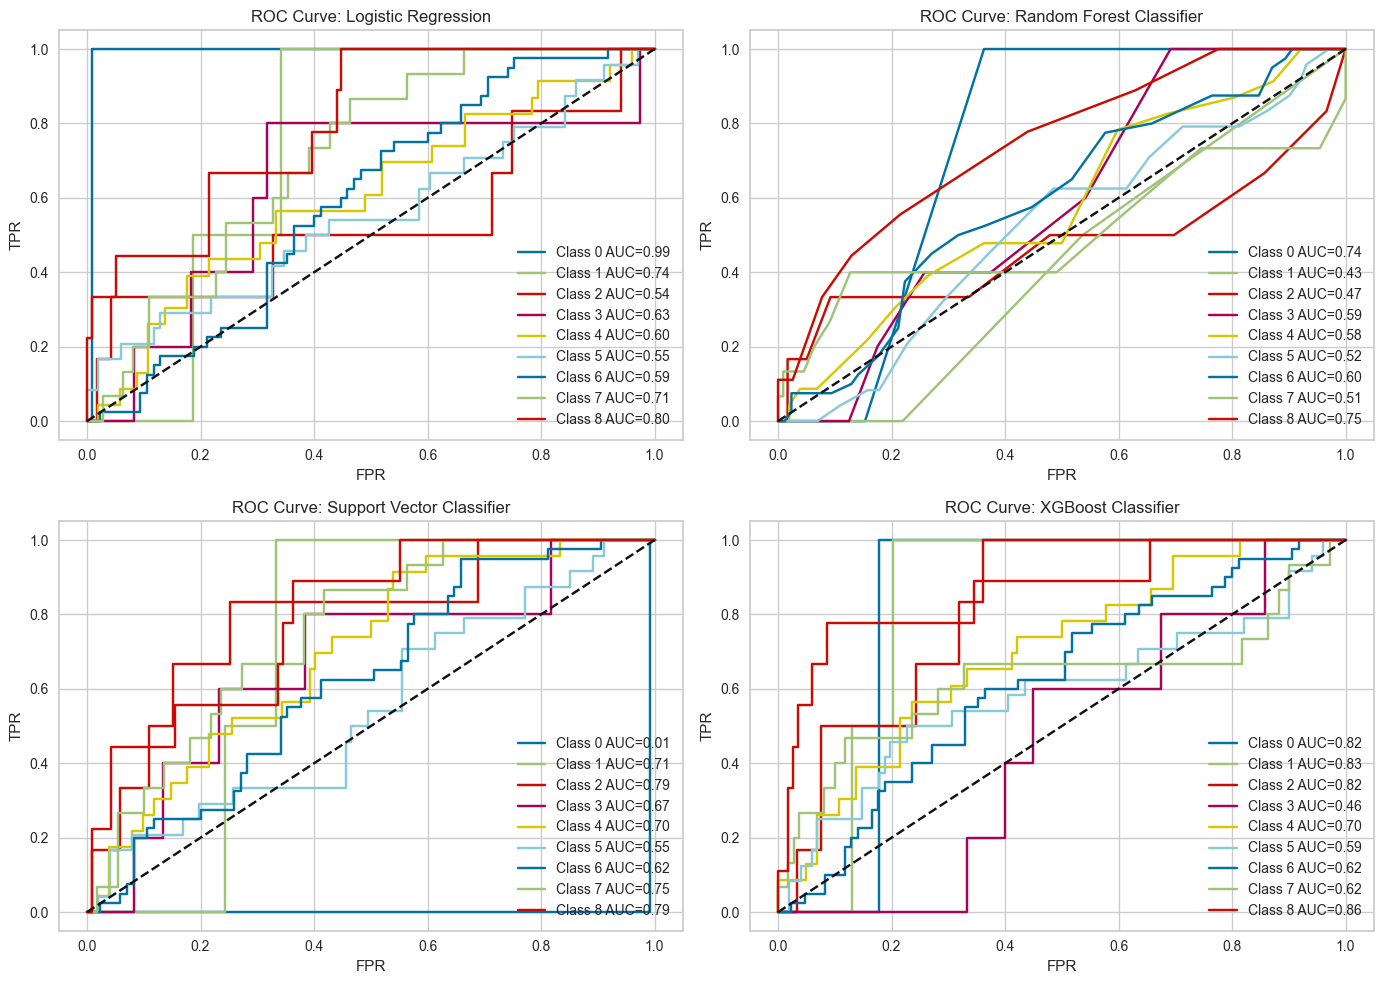

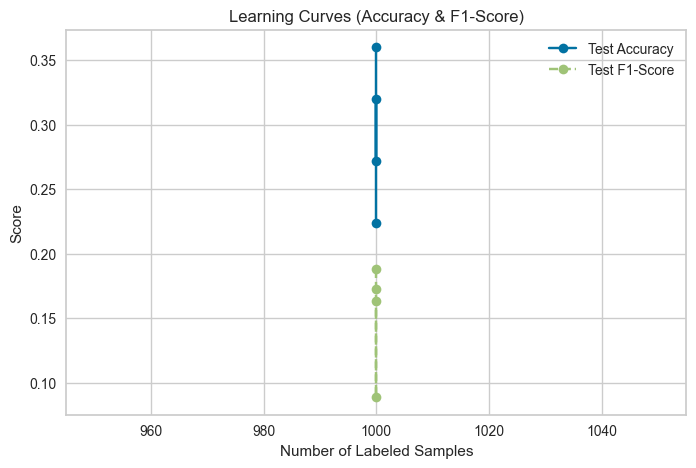

In [57]:
train_and_evaluate(labeled_embeddings_transformer, labeled_data['review_score'])


Training Logistic Regression...

Metrics for Logistic Regression:
Validation Accuracy: 0.0400
Validation Precision (macro): 0.1938
Validation Recall (macro): 0.0360
Validation F1-score (macro): 0.0471
Test Accuracy: 0.0960
Test Precision (macro): 0.1537
Test Recall (macro): 0.1382
Test F1-score (macro): 0.0971
Confusion Matrix:
[[ 0  1  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0]
 [ 3  2  0  1  0  0  0  0  0]
 [ 0  3  0  1  0  1  0  0  0]
 [ 6  9  0  1  1  4  0  1  1]
 [ 5 10  0  1  1  4  0  1  2]
 [ 9 19  0  2  0  5  0  3  2]
 [ 5  4  0  0  0  0  0  5  1]
 [ 5  2  0  0  0  1  0  1  0]]

Training Random Forest Classifier...


c:\Users\Helia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.




Metrics for Random Forest Classifier:
Validation Accuracy: 0.2960
Validation Precision (macro): 0.2517
Validation Recall (macro): 0.1431
Validation F1-score (macro): 0.1228
Test Accuracy: 0.3440
Test Precision (macro): 0.1192
Test Recall (macro): 0.1326
Test F1-score (macro): 0.0975
Confusion Matrix:
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  1  5  0  0]
 [ 0  0  0  0  0  1  4  0  0]
 [ 0  0  0  0  1  4 18  0  0]
 [ 0  0  0  0  0  6 18  0  0]
 [ 0  0  0  0  1  2 36  1  0]
 [ 0  0  0  0  0  1 14  0  0]
 [ 0  0  0  0  1  0  8  0  0]]

Training Support Vector Classifier...

Metrics for Support Vector Classifier:
Validation Accuracy: 0.1840
Validation Precision (macro): 0.0395
Validation Recall (macro): 0.1738
Validation F1-score (macro): 0.0514
Test Accuracy: 0.1840
Test Precision (macro): 0.0365
Test Recall (macro): 0.1167
Test F1-score (macro): 0.0490
Confusion Matrix:
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  1  0  0  0  0  1  0  0]
 [ 2  1  0  0  0  0  3 

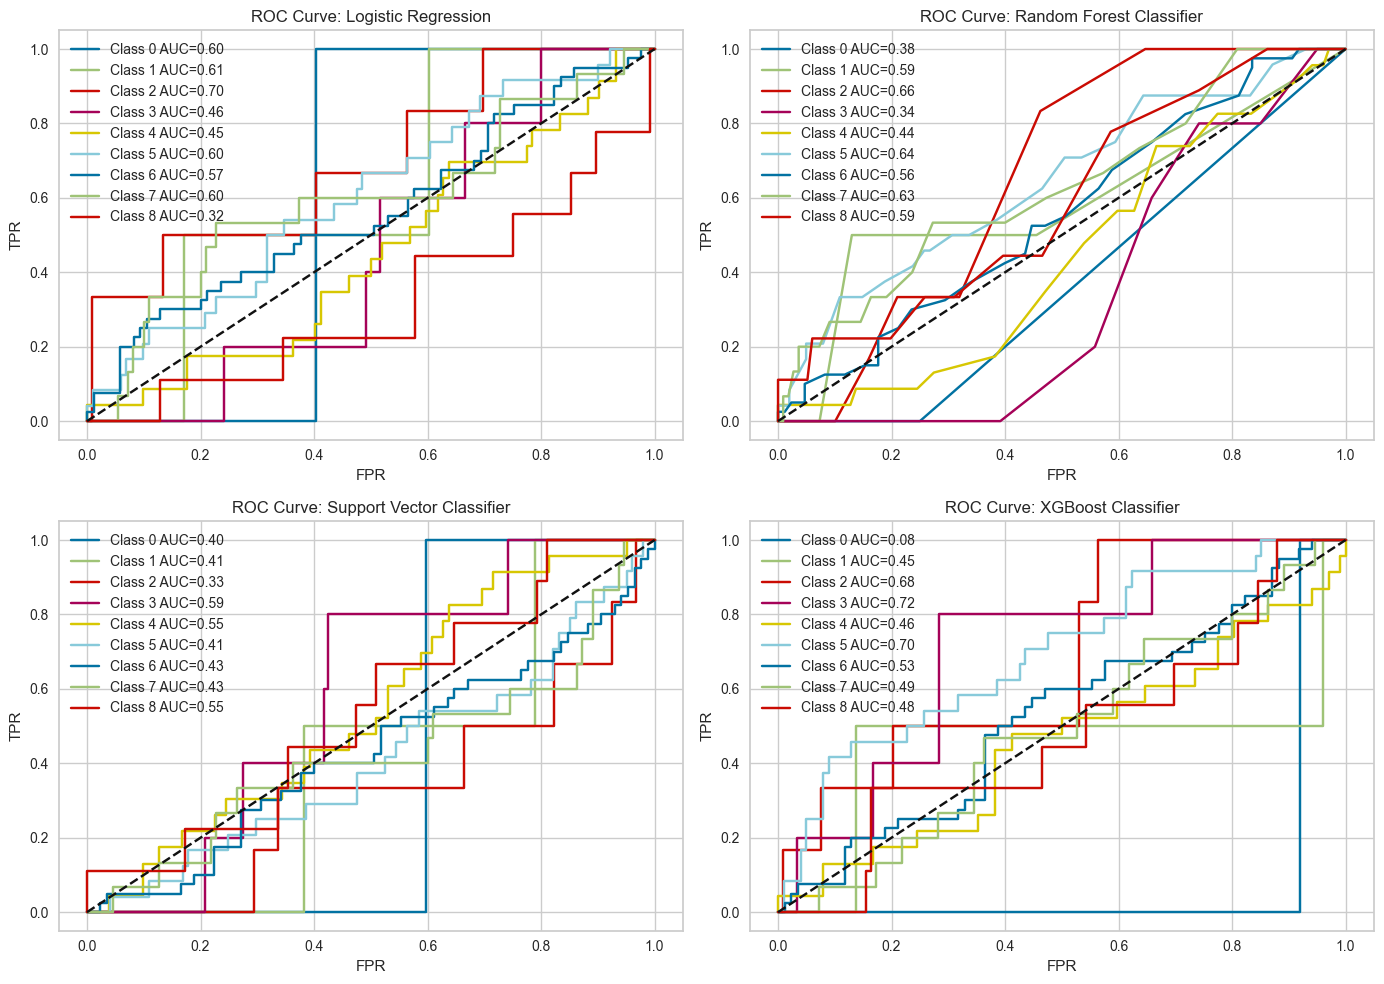

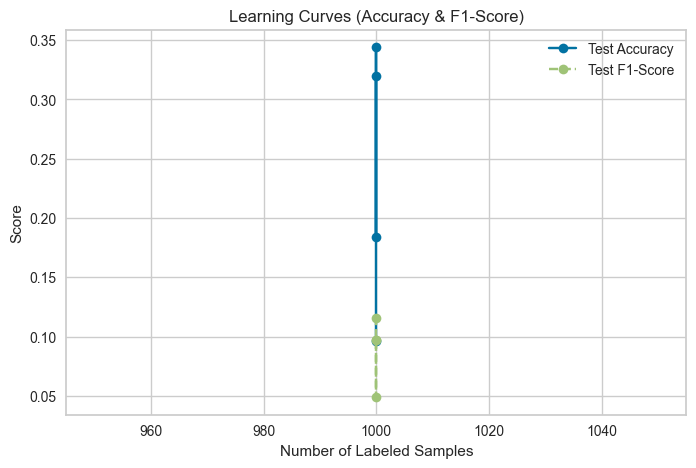

In [58]:
train_and_evaluate(labeled_embeddings_w2vec, labeled_data['review_score'])


In [ ]:
def pseudo_labeling(X_labeled, y_labeled, X_unlabeled, X_test, y_test,
                    base_model=XGBClassifier(
                        objective="multi:softprob",
                        use_label_encoder=False,
                        eval_metric="mlogloss",
                        random_state=42
                    ),
                    confidence_threshold=0.2,
                    max_iterations=3):

    X_train, y_train = X_labeled.copy(), y_labeled.copy()

    acc_list = []
    f1_list = []
    sample_counts = []

    for iteration in range(max_iterations):
        print(f"\n=== Iteration {iteration+1} ===")
        print(f"Unlabeled pool size: {len(X_unlabeled)}")

        model = clone(base_model)
        model.fit(X_train, y_train)

        if len(X_unlabeled) == 0:
            print("No unlabeled samples left.")
            break

        probs = model.predict_proba(X_unlabeled)
        preds = np.argmax(probs, axis=1)
        confidences = np.max(probs, axis=1)

        print(f"Confidence stats: min={confidences.min():.3f}, max={confidences.max():.3f}, mean={confidences.mean():.3f}")

        mask = confidences >= confidence_threshold
        print(f"Samples above threshold {confidence_threshold}: {mask.sum()}")

        X_pseudo = X_unlabeled[mask]
        y_pseudo = preds[mask]

        if len(X_pseudo) == 0:
            print("No pseudo-labeled samples selected.")
            break

        X_train = np.vstack([X_train, X_pseudo])
        y_train = np.concatenate([y_train, y_pseudo])
        X_unlabeled = X_unlabeled[~mask]

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        print(f"Test Accuracy: {acc:.4f}, Macro-F1: {f1:.4f}")

        acc_list.append(acc)
        f1_list.append(f1)
        sample_counts.append(len(y_train))

    print("\n=== Final ROC Curve ===")
    y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
    probs_test = model.predict_proba(X_test)

    roc_data = []
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs_test[:, i])
        roc_auc = auc(fpr, tpr)
        print(f"Class {i} AUC: {roc_auc:.4f}")
        roc_data.append(pd.DataFrame({
            "FPR": fpr,
            "TPR": tpr,
            "Class": f"Class {i}",
            "AUC": roc_auc
        }))

    combined_df = pd.concat(roc_data)
    fig = px.line(
        combined_df,
        x="FPR",
        y="TPR",
        color="Class",
        line_group="Class",
        hover_data=["AUC"],
        title="ROC Curve for Final Pseudo-Labeling Iteration"
    )
    fig.add_shape(type="line", x0=0, y0=0, x1=1, y1=1,
                  line=dict(dash="dash", color="gray"))
    fig.update_layout(xaxis_title="False Positive Rate", yaxis_title="True Positive Rate")
    fig.show()

    
    fig_lc = go.Figure()
    fig_lc.add_trace(go.Scatter(x=sample_counts, y=acc_list, mode='lines+markers', name='Test Accuracy'))
    fig_lc.add_trace(go.Scatter(x=sample_counts, y=f1_list, mode='lines+markers', name='Macro F1-score'))
    fig_lc.update_layout(
        title="Learning Curve During Pseudo-Labeling",
        xaxis_title="Number of Labeled Samples",
        yaxis_title="Score",
        legend_title="Metric"
    )
    fig_lc.show()

    
    return model

In [64]:
X_train, X_val, y_train, y_val = train_test_split(
    labeled_embeddings_transformer,  labeled_data['review_score'], test_size=0.2, random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

final_model = pseudo_labeling(
    X_labeled=X_train, 
    y_labeled=y_train_enc, 
    X_unlabeled=unlabeled_embeddings_transformer, 
    X_test=X_val, 
    y_test=y_val_enc,
    confidence_threshold=0.97,
    max_iterations=5
)



=== Iteration 1 ===
Unlabeled pool size: 5000
Confidence stats: min=0.192, max=0.997, mean=0.651
Samples above threshold 0.97: 120
Test Accuracy: 0.3520, Macro-F1: 0.1850

=== Iteration 2 ===
Unlabeled pool size: 4880
Confidence stats: min=0.191, max=0.999, mean=0.666
Samples above threshold 0.97: 218
Test Accuracy: 0.3400, Macro-F1: 0.1633

=== Iteration 3 ===
Unlabeled pool size: 4662
Confidence stats: min=0.207, max=0.999, mean=0.685
Samples above threshold 0.97: 325
Test Accuracy: 0.3360, Macro-F1: 0.1526

=== Iteration 4 ===
Unlabeled pool size: 4337
Confidence stats: min=0.207, max=0.999, mean=0.710
Samples above threshold 0.97: 419
Test Accuracy: 0.3360, Macro-F1: 0.1532

=== Iteration 5 ===
Unlabeled pool size: 3918
Confidence stats: min=0.189, max=0.999, mean=0.732
Samples above threshold 0.97: 462
Test Accuracy: 0.3440, Macro-F1: 0.1186

=== Final ROC Curve ===
Class 0 AUC: 0.9639
Class 1 AUC: 0.5169
Class 2 AUC: 0.7457
Class 3 AUC: 0.6450
Class 4 AUC: 0.6115
Class 5 AUC: 0.


Round 1:
Accuracy: 0.316, F1-score: 0.082, Training size: 1000
Select labels for these 1 samples:
Sample 1: Text: Outstanding. It's the only way to describe the first work of the Spanish workgroup Akaoni Studios. They wanted to create a shooter involved with the classical gameplay-style of the genre and they've done it. It's probably the most beautiful game on the WiiWare - it's a pity that its lifespan it's just a couple of hours. Add a few days if you play it with a friend, but without any online options, there's not much to do after completing the game with very character., Current label: 9

Round 2:
Accuracy: 0.317, F1-score: 0.082, Training size: 1001
Select labels for these 1 samples:
Sample 1: Text: This third game in the snowboarding series features a complete overhaul, dropping the whole race-circuit idea and taking a more open-ended, Grand Theft Auto–like approach to snowboard competition. [Grade = A+], Current label: 4

Round 3:
Accuracy: 0.323, F1-score: 0.083, Training si

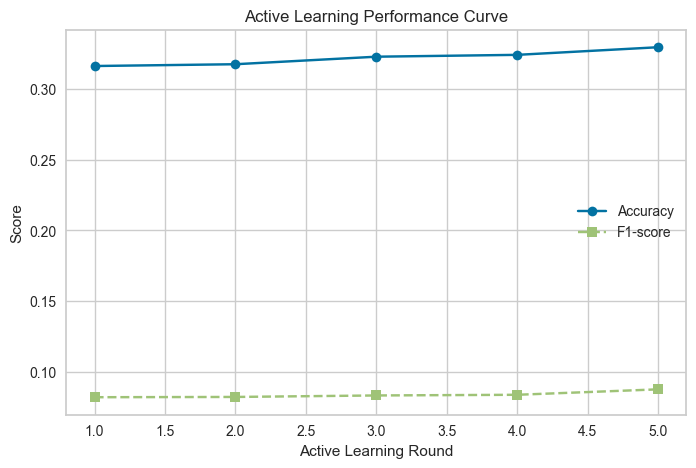

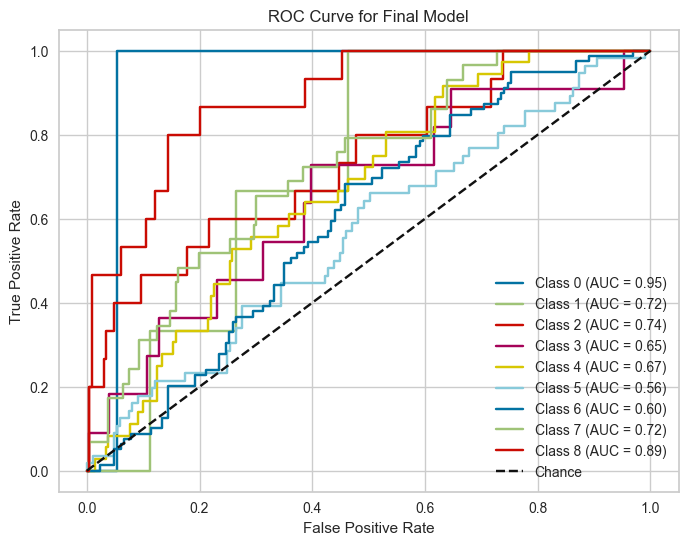

In [65]:
X = labeled_embeddings_transformer.to_numpy() if hasattr(labeled_embeddings_transformer, "to_numpy") else labeled_embeddings_transformer
y = labeled_data['review_score'].to_numpy() if hasattr(labeled_data['review_score'], "to_numpy") else labeled_data['review_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def least_confidence(probs):
    return 1 - np.max(probs, axis=1)

def margin_sampling(probs):
    part = np.sort(probs, axis=1)[:, -2:]
    return part[:, 1] - part[:, 0]

def entropy_sampling(probs):
    return entropy(probs.T)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

performance = []
f1_scores = []
rounds = 5
k = 1

for r in range(rounds):
    print(f"\nRound {r+1}:")

    acc = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')

    performance.append(acc)
    f1_scores.append(f1)

    print(f"Accuracy: {acc:.3f}, F1-score: {f1:.3f}, Training size: {len(y_train)}")

    probs = model.predict_proba(X_test)
    uncertainty_scores = entropy_sampling(probs)
    query_idx = np.argsort(uncertainty_scores)[-k:]

    print(f"Select labels for these {k} samples:")
    X_new, y_new = X_test[query_idx], y_test[query_idx]

    for i in range(k):
        comment_text = unlabeled_data.iloc[query_idx[i]]['review_text']
        print(f"Sample {i+1}: Text: {comment_text}, Current label: {y_new[i]}")
        label = int(input(f"Enter the label for this sample (current label is {y_new[i]}): "))
        y_new[i] = label

    X_train = np.vstack([X_train, X_new])
    y_train = np.concatenate([y_train, y_new])

    mask = np.ones(len(X_test), dtype=bool)
    mask[query_idx] = False
    X_test, y_test = X_test[mask], y_test[mask]

    model.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plt.plot(range(1, rounds+1), performance, marker='o', label='Accuracy')
plt.plot(range(1, rounds+1), f1_scores, marker='s', linestyle='--', label='F1-score')
plt.xlabel("Active Learning Round")
plt.ylabel("Score")
plt.title("Active Learning Performance Curve")
plt.legend()
plt.grid(True)
plt.show()

y_test_bin = label_binarize(y_test, classes=np.unique(y))
probs_final = model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs_final[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Final Model")
plt.legend()
plt.grid(True)
plt.show()

## Effectiveness Comparison

### **Pseudo-Labeling**
- **Mechanism**: Trains a model on labeled data, then uses it to assign labels to unlabeled data. High-confidence predictions are added back to the training set.
- **Performance**: Often yields **steady improvements**, especially when the model is already reasonably accurate. It benefits from the abundance of unlabeled data.
- **Risk**: If the model is wrong early on, it may reinforce its own mistakes—this is known as **confirmation bias**.

### **Active Learning**
- **Mechanism**: Selects the most informative or uncertain samples from the unlabeled pool and queries a human annotator for labels.
- **Performance**: Can lead to **sharp improvements** in fewer rounds, especially when labeling budget is tight. It’s highly efficient in terms of label value.
- **Risk**: Requires human input, which can be **costly and slow**, especially for large datasets or complex tasks.

---

## Which Method Yields Greater Improvement?

It depends on the context:

| Scenario | Preferred Method | Why |
|---------|------------------|-----|
| **Small labeled set, large unlabeled pool** | Pseudo-Labeling | Leverages scale and model confidence |
| **High annotation cost or expert labeling needed** | Active Learning | Minimizes labeling effort by focusing on uncertain samples |
| **Early-stage model with low accuracy** | Active Learning | Avoids reinforcing errors from weak pseudo-labels |
| **Well-performing base model** | Pseudo-Labeling | Can safely expand training set with confident predictions |

In practice, **hybrid approaches** that combine both methods often outperform either alone.

---

## Trade-offs and Pitfalls

### Pseudo-Labeling
- **Pros**:
  - Scales easily with large unlabeled datasets
  - No human intervention needed after initial labeling
- **Cons**:
  - Confirmation bias: model may reinforce its own errors
  - Sensitive to confidence thresholds
  - May struggle with class imbalance or noisy data

### Active Learning
- **Pros**:
  - Efficient use of labeling budget
  - Focuses on most informative samples
- **Cons**:
  - Requires human annotators
  - Slower iteration cycles
  - May miss out on useful unlabeled data not selected